In [1]:
import geostochpy
north_lat=-30
nx=16
ny=50
width=160
length=500
route_trench = geostochpy.get_data('trench-chile.txt')
lonsfosa, latsfosa,strikefosa  = geostochpy.load_trench(route_trench)
slabdep,slabdip,slabstrike,slabrake=geostochpy.load_files_slab2(zone='south_america',rake=True)
#X_grid,Y_grid,lon_flat,lat_flat=geostochpy.make_fault_alongstriketrench(lonsfosa, latsfosa,strikefosa,north_lat, nx, ny, width, length)


In [2]:
X_grid,Y_grid,lon_flat,lat_flat=geostochpy.make_fault_alongstriketrench(lonsfosa, latsfosa,strikefosa,north_lat, nx, ny, width, length)
dep,dip,strike,rake=geostochpy.interp_slab(X_grid,Y_grid,slabdep,slabdip,slabstrike,slabrake)



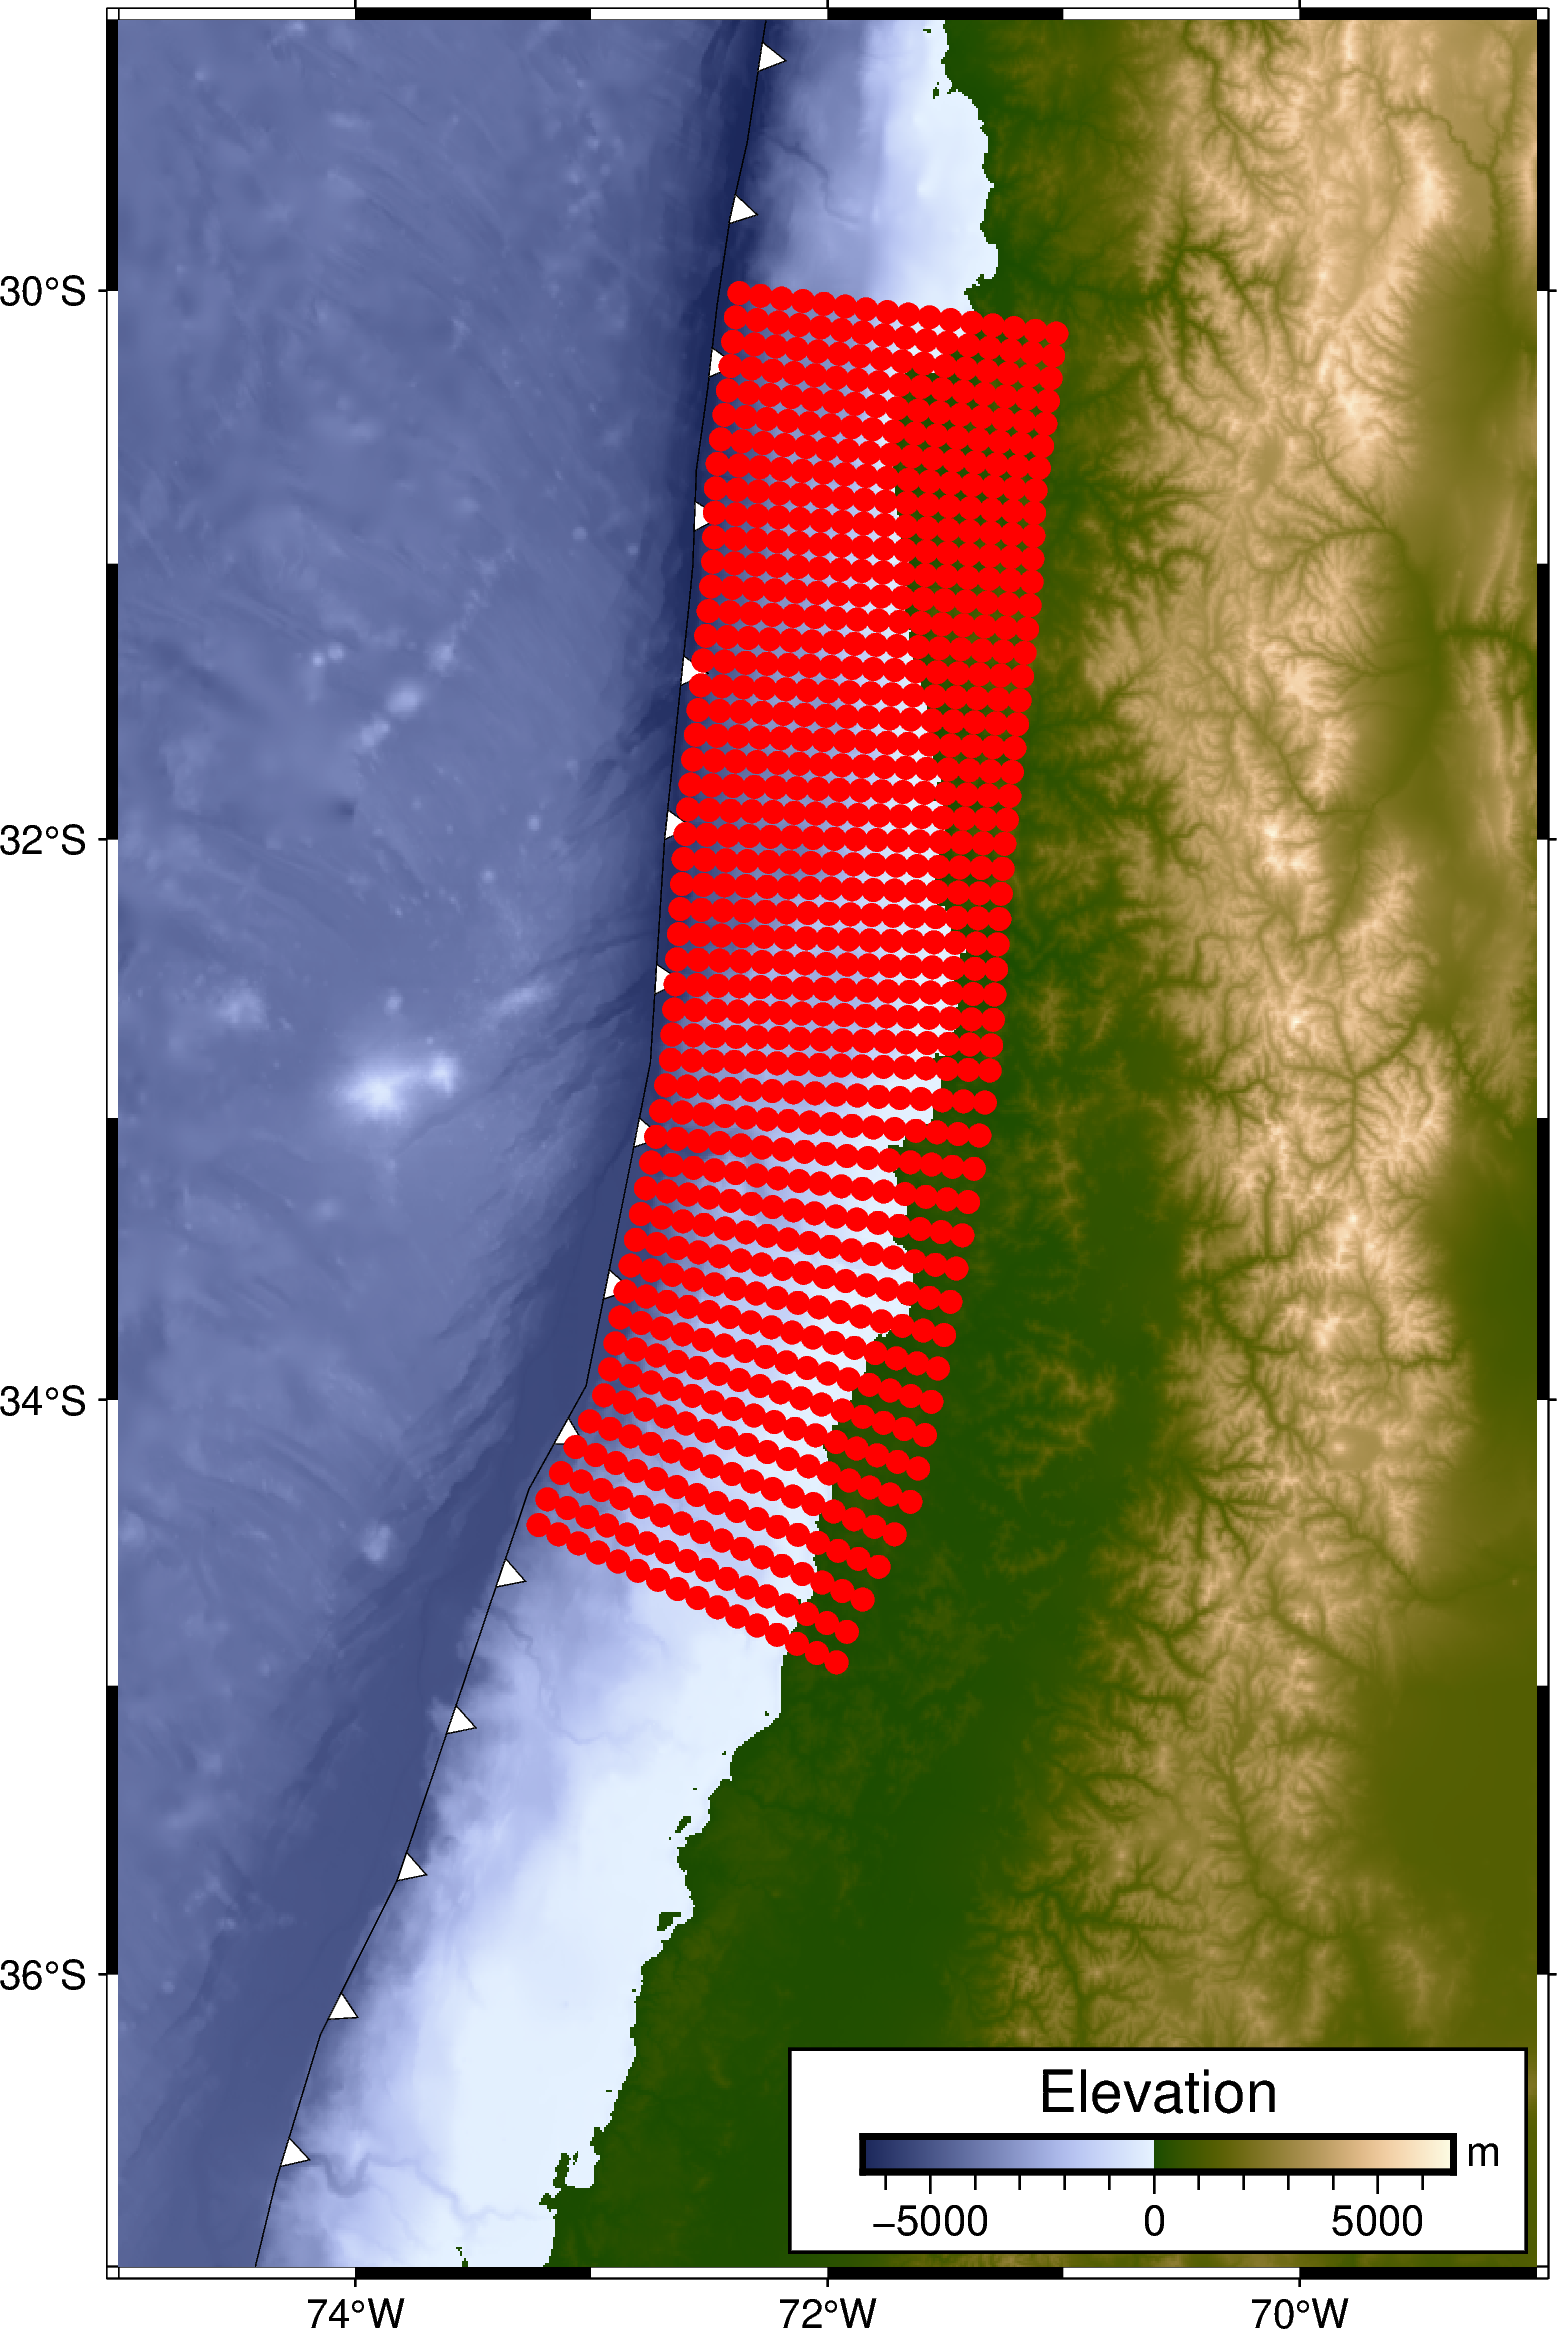

In [6]:
geostochpy.plot_grid([-75,-69,-37,-29],lonsfosa,latsfosa,lon_flat,lat_flat)

In [4]:
import numpy as np
trench=np.array([lonsfosa,latsfosa,strikefosa]).T[::-1]
np.savetxt('trench-chile.txt',trench,fmt='%f %f %f')

In [3]:
import numpy as np
from scipy.interpolate import LinearNDInterpolator
dy = length / ny
j = np.arange(ny)
lat_trench = north_lat - geostochpy.km2deg(dy * j)
lon_trench = np.interp(lat_trench, latsfosa, lonsfosa)

# Interpolar los datos
slabstrike_interp = LinearNDInterpolator(list(zip(lonsfosa,latsfosa)), strikefosa)
strike = slabstrike_interp(lon_trench, lat_trench)

# Crear matrices de índices
I, J = np.meshgrid(np.arange(nx), j)

# Repetir el array strike en las columnas nx veces
strike_repeated = np.tile(strike[:, np.newaxis], (1, nx))

# Calcular latitud y longitud sin usar bucles
dx = width / nx
lat_offset = geostochpy.km2deg(np.sin(np.deg2rad(strike_repeated)) * (dx * (I + 1) - 1 / 2))
lon_offset = geostochpy.km2deg(np.cos(np.deg2rad(strike_repeated)) * (dx * (I + 1) - 1 / 2))

lat = lat_trench[J] - lat_offset
lon = lon_trench[J] + lon_offset

# Aplanar los resultados si es necesario
lat_flat = lat.flatten()
lon_flat = lon.flatten()

In [ ]:
def plot_slip_gmt(region,X_grid,Y_grid,lonfosa,latfosa,Slip,dx,dy,filename=False):
    """
    Plot a Slip grid of data on a grid

    :param region: [description]
    :type region: [type]
    :param X_grid: [description]
    :type X_grid: [type]
    :param Y_grid: [description]
    :type Y_grid: [type]
    :param lonfosa: [description]
    :type lonfosa: [type]
    :param latfosa: [description]
    :type latfosa: [type]
    :param Slip: [description]
    :type Slip: [type]
    :param dx: [description]
    :type dx: [type]
    :param dy: [description]
    :type dy: [type]
    :param archivo_salida: [description]
    :type archivo_salida: [type]
    """
    import numpy as np
    import pygmt
    # define parameters for plotting
    latmax=np.max(Y_grid.flat)
    latmin=np.min(Y_grid.flat)
    lonmax=np.max(X_grid.flat)
    lonmin=np.min(X_grid.flat)
    reg2=(lonmin,lonmax,latmin,latmax)
    #
    fig=pygmt.Figure()
    spacing=f"{dx}k/{dy}k"
    cmap2use = 'rainbow'
    cmap=pygmt.makecpt(cmap = 
              cmap2use, 
              series = [np.min(Slip.flatten())-1, np.max(Slip.flatten())+3,5], 
              background='i',
              continuous=True)
    grid=pygmt.xyz2grd(x=X_grid.flatten(),y=Y_grid.flatten(),z=Slip.flatten(),region = reg2,spacing=spacing)
    grid=pygmt.grdsample(grid,spacing=0.001,region=reg2,verbose='q')
    cmap=pygmt.grd2cpt(grid=grid,cmap='rainbow',nlevels=True,continuous=True)
    fig.basemap(region=region, projection="Q12c", frame='ag')
    fig.coast(land="darkgray",projection='Q12c',frame=True,water="lightblue",borders=["1/0.5p,black", "2/0.5p,gray", "3/0.5p,blue"])
    fig.grdimage(grid, 
            cmap=cmap,
            projection='Q12c',
            nan_transparent=True,
            interpolation='l+a+t1.0'
            )
    # fig.grdcontour(grid=grid,projection='Q12c')
    # fig.grdcontour(grid=grid,interval=3,annotation=0)
    fig.plot(x=lonfosa,y=latfosa,
        projection='Q12c',
        region=region,
        pen="1p",
        fill="white",
        style="f0.5i/0.1i+r+t+o1")
    fig.colorbar(frame=['a+3',"x+lSlip[m]"],cmap=cmap,projection='Q12c')
    with fig.inset(position="jTL+w3.5c+o0.2c", margin=0, box="+p1.5p,gold"):
        # Create a figure in the inset using coast. This example uses the azimuthal
        # orthogonal projection centered at 47E, 20S. The land color is set to
        # "gray" and Madagascar is highlighted in "red3".
        fig.coast(
            region="g",
            projection="G-70/-33/?",
            land="gray",
            water="royalblue",
            dcw="CL+gred3",
        )
    fig.shift_origin(yshift="0c",xshift="13c")
    #
    data_lat=np.ones((np.unique(Y_grid.flatten()).size,2))
    data_lat[:,1]=np.unique(Y_grid.flatten())[::-1]
    data_lat[:,0]=np.mean(Slip,axis=1)
    fig.plot(
        projection="X2c/12c",
        # Note that the y-axis annotation "Counts" is shown in x-axis direction
        # due to the rotation caused by horizontal=True
        frame=["ag", "WSne","xaf+lSlip mean[m]"],
        region=[0,np.max(np.mean(Slip,axis=1))+1,region[2],region[3]],
        x=data_lat[:,0],
        y=data_lat[:,1],
        pen="2p,black",
        )
    fig.shift_origin(yshift='13c',xshift='-13c')
    fig.plot(
    projection="X12c/3c",
    # Note that the y-axis annotation "Counts" is shown in x-axis direction
    # due to the rotation caused by horizontal=True
    frame=["ag", "WSne","yaf+lSlip mean[m]"],
    region=[region[0],region[1],0,np.max(np.mean(Slip,axis=0))+1],
    x=np.mean(X_grid,axis=0),
    y=np.mean(Slip,axis=0),
    pen="2p,black",
    )
    np.mean(X_grid,axis=0),np.mean(Slip,axis=0)
    # Shift the plot origin and add right margin histogram
    if filename != False:
        fig.savefig(filename) 
    else:
        fig.show()
    return